http://www.ercot.com/gridinfo/load

The archives are also there:
http://www.ercot.com/gridinfo/load/load_hist

There is a difference between the archives and real time, as I have learned :) The real time is based on telemetry substation data, whereas the historical is based on final values. This usually accounts for about a 1% difference, mostly white noise. It would be a good exercise for students to both correct this historical bias and also build timeseries forecasting models on this live data feed. ERCOT also publishes their own load forecasts, so you can use that as a good baseline for any model.

In [222]:
!sudo apt-get install unzip
!pip install -U pip
!pip install -U statsmodels xlrd PyMySQL sqlalchemy sql_magic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.6 MB/s eta 0:00:00


In [223]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [224]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])

In [225]:
import pandas as pd
import numpy as np

In [226]:
import datetime as dt

def str_to_datetime(date_str):
    if date_str.endswith("24:00"):
        return pd.to_datetime(date_str[:10], format="%m/%d/%Y") + dt.timedelta(days=1)
    else:
        return pd.to_datetime(date_str, format="%m/%d/%Y %H:%M")

### 2021

In [227]:
!curl "https://www.ercot.com/files/docs/2021/11/12/Native_Load_2021.zip" -o native_load_2021.zip
!unzip -o native_load_2021.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1068k  100 1068k    0     0   368k      0  0:00:02  0:00:02 --:--:--  368k
Archive:  native_load_2021.zip
  inflating: Native_Load_2021.xlsx   


In [228]:
df2021 = pd.read_excel("Native_Load_2021.xlsx")

In [229]:
df2021.dtypes

Hour Ending     object
COAST          float64
EAST           float64
FWEST          float64
NORTH          float64
NCENT          float64
SOUTH          float64
SCENT          float64
WEST           float64
ERCOT          float64
dtype: object

In [230]:
import re
for g in df2021["Hour Ending"].values:
    if not re.match(r"^\d\d/\d\d/\d\d\d\d \d\d:\d\d$",g):
        print(g)

11/07/2021 02:00 DST


In [231]:
df2021["Hour Ending"].replace("11/07/2021 02:00 DST", "11/07/2021 02:00", inplace=True)

In [232]:
df2021['date'] = df2021["Hour Ending"].apply(str_to_datetime)
df2021.drop('Hour Ending', inplace=True, axis='columns')
df2021.set_index('date', inplace=True)

df2021.sort_index(inplace=True)

### 2020

In [233]:
!curl "https://www.ercot.com/files/docs/2021/01/12/Native_Load_2020.zip" -o native_load_2020.zip
!unzip -o native_load_2020.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1074k  100 1074k    0     0  2545k      0 --:--:-- --:--:-- --:--:-- 2545k
Archive:  native_load_2020.zip
  inflating: Native_Load_2020.xlsx   


In [234]:
df2020 = pd.read_excel("Native_Load_2020.xlsx")
df2020

,HourEnding,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT
0,01/01/2020 01:00,9890.091522,1364.278198,3721.972022,773.878822,11719.863767,2707.841517,5473.246071,1172.943179,36824.115099
1,01/01/2020 02:00,9751.586415,1369.569694,3735.514034,775.063743,11639.455987,2706.844837,5387.380467,1165.951313,36531.366488
2,01/01/2020 03:00,9603.421087,1373.528720,3735.851866,774.153775,11515.421981,2650.378864,5270.331958,1149.076769,36072.165020
3,01/01/2020 04:00,9501.585599,1365.630426,3743.517881,778.097301,11518.359020,2586.709109,5200.960612,1141.301918,35836.161867
4,01/01/2020 05:00,9499.426925,1385.600323,3753.898979,784.077729,11649.293449,2548.852381,5230.298774,1147.094161,35998.542722
...,...,...,...,...,...,...,...,...,...,...
8779,12/31/2020 20:00,12068.071946,1788.474092,3979.115067,1005.372994,16508.360213,3718.100777,8640.867717,1640.840548,49349.203353
8780,12/31/2020 21:00,11818.903690,1726.770658,3962.905180,969.428095,15752.272222,3637.379800,8505.529827,1607.467424,47980.656897
8781,12/31/2020 22:00,11560.408167,1680.800823,3925.708218,928.517370,15179.536570,3571.725609,8334.601541,1573.542580,46754.840878
8782,12/31/2020 23:00,11339.877692,1627.080961,3895.376959,891.856675,14650.060694,3524.972799,8024.802495,1521.383987,45475.412261


In [235]:
df2020["HourEnding"].replace("11/01/2020 02:00 DST", "11/01/2020 02:00", inplace=True)
df2020['date'] = df2020["HourEnding"].apply(str_to_datetime)
df2020.drop('HourEnding', inplace=True, axis='columns')
df2020.set_index('date', inplace=True)

df2020.sort_index(inplace=True)

### 2019 

In [236]:
!curl "https://www.ercot.com/files/docs/2020/01/09/Native_Load_2019.zip" -o native_load_2019.zip
!unzip -o native_load_2019.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1067k  100 1067k    0     0  2447k      0 --:--:-- --:--:-- --:--:-- 2447k
Archive:  native_load_2019.zip
  inflating: Native_Load_2019.xlsx   


In [237]:
df2019 = pd.read_excel("Native_Load_2019.xlsx")



In [238]:
import re
for g in df2019["HourEnding"].values:
    if not re.match(r"^\d\d/\d\d/\d\d\d\d \d\d:\d\d$",g):
        print(g)

11/03/2019 02:00 DST


In [239]:
df2019["HourEnding"].replace("11/03/2019 02:00 DST", "11/03/2019 02:00", inplace=True)

In [240]:
len(df2019)

8760

In [241]:
df2019['date'] = df2019["HourEnding"].apply(str_to_datetime)
df2019.drop('HourEnding', inplace=True, axis='columns')
df2019.set_index('date', inplace=True)

df2019.sort_index(inplace=True)

### 2018

In [242]:
!curl "https://www.ercot.com/files/docs/2019/01/07/native_load_2018.zip" -o native_load_2018.zip
!unzip -o native_load_2018.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1067k  100 1067k    0     0  3356k      0 --:--:-- --:--:-- --:--:-- 3346k
Archive:  native_load_2018.zip
  inflating: Native_Load_2018.xlsx   


In [243]:
df2018 = pd.read_excel("Native_Load_2018.xlsx")


In [244]:
import re
for g in df2018["HourEnding"].values:
    if not re.match(r"^\d\d/\d\d/\d\d\d\d \d\d:\d\d$",g):
        print(g)

11/04/2018 02:00 DST


In [245]:
df2018["HourEnding"].replace("11/04/2018 02:00 DST", "11/04/2018 02:00", inplace=True)

In [246]:

df2018['date'] = df2018["HourEnding"].apply(str_to_datetime)
df2018.drop('HourEnding', inplace=True, axis='columns')
df2018.set_index('date', inplace=True)

### 2017

In [247]:
!curl "https://www.ercot.com/files/docs/2018/01/09/native_load_2017.zip" -o native_load_2017.zip
!unzip -o native_load_2017.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1093k  100 1093k    0     0  3188k      0 --:--:-- --:--:-- --:--:-- 3188k
Archive:  native_load_2017.zip
  inflating: native_Load_2017.xlsx   


In [248]:
df2017 = pd.read_excel("native_Load_2017.xlsx")

In [249]:
import re
for g in df2017["Hour Ending"].values:
    if not re.match(r"^\d\d/\d\d/\d\d\d\d \d\d:\d\d$",g):
        print(g)

11/05/2017 02:00 DST


In [250]:
df2017["Hour Ending"].replace("11/05/2017 02:00 DST", "11/05/2017 02:00", inplace=True)

In [251]:
df2017['date'] = df2017["Hour Ending"].apply(str_to_datetime)
df2017.drop('Hour Ending', inplace=True, axis='columns')
df2017.set_index('date', inplace=True)

In [252]:
len(df2017)/24

365.0

### 2016

In [253]:
!curl "https://www.ercot.com/files/docs/2017/01/10/native_Load_2016.zip" -o native_load_2016.zip
!unzip -o native_load_2016.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1095k  100 1095k    0     0  1936k      0 --:--:-- --:--:-- --:--:-- 1932k
Archive:  native_load_2016.zip
  inflating: native_Load_2016.xlsx   


In [254]:
df2016 = pd.read_excel("native_Load_2016.xlsx")

In [255]:
df2016.dtypes

Hour_End    datetime64[ns]
COAST              float64
EAST               float64
FAR_WEST           float64
NORTH              float64
NORTH_C            float64
SOUTHERN           float64
SOUTH_C            float64
WEST               float64
ERCOT              float64
dtype: object

In [256]:
df2016.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)

In [257]:
df2016.set_index('date', inplace=True)

In [258]:
df2016 = df2016.fillna(method="ffill")

In [259]:
len(df2016)/24

366.0

### 2015

In [260]:
!curl "https://www.ercot.com/files/docs/2016/01/07/native_load_2015.xls" -o native_load_2015.xls


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1757k  100 1757k    0     0  5651k      0 --:--:-- --:--:-- --:--:-- 5651k


In [261]:
df2015 = pd.read_excel("native_load_2015.xls")

In [262]:
df2015.head(3)

,Hour_End,COAST,EAST,FAR_WEST,NORTH,NORTH_C,SOUTHERN,SOUTH_C,WEST,ERCOT
0,2015-01-01 01:00:00.003,9844.200268,1350.784678,2078.060021,901.770195,13640.024978,3607.904503,6731.301663,1470.814721,39624.861027
1,2015-01-01 01:59:59.997,9653.456269,1333.434943,2057.993265,890.150373,13425.121941,3609.619438,6602.935629,1440.832944,39013.544802
2,2015-01-01 03:00:00.000,9502.299659,1323.908498,2039.019542,880.926639,13286.070909,3573.158363,6530.663273,1430.495044,38566.541927


In [263]:
df2015.dtypes

Hour_End    datetime64[ns]
COAST              float64
EAST               float64
FAR_WEST           float64
NORTH              float64
NORTH_C            float64
SOUTHERN           float64
SOUTH_C            float64
WEST               float64
ERCOT              float64
dtype: object

In [264]:
df2015.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)

In [265]:
df2015.set_index('date', inplace=True)

In [266]:
len(df2015)/24

365.0

### 2014

In [267]:
!curl "https://www.ercot.com/files/docs/2015/10/22/2014_ercot_hourly_load_data.xls" -o native_load_2014.xls


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1757k  100 1757k    0     0  4234k      0 --:--:-- --:--:-- --:--:-- 4234k


In [268]:
df2014 = pd.read_excel("native_load_2014.xls")

In [269]:
df2014.head(3)

,Hour_End,COAST,EAST,FAR_WEST,NORTH,NORTH_C,SOUTHERN,SOUTH_C,WEST,ERCOT
0,2014-01-01 01:00:00.003,9101.691219,1338.197939,1820.206244,793.458458,12298.801147,3236.109065,6121.146143,1102.523505,35812.133719
1,2014-01-01 01:59:59.997,8907.975782,1328.940064,1809.180861,791.141630,12297.109823,3246.493375,6091.018850,1098.774771,35570.635156
2,2014-01-01 03:00:00.000,8738.460973,1317.990846,1804.524573,789.791906,12285.295247,3217.721388,6060.017515,1097.716762,35311.519210


In [270]:
df2014.dtypes

Hour_End    datetime64[ns]
COAST              float64
EAST               float64
FAR_WEST           float64
NORTH              float64
NORTH_C            float64
SOUTHERN           float64
SOUTH_C            float64
WEST               float64
ERCOT              float64
dtype: object

In [271]:
df2014.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)

In [272]:
df2014.set_index('date', inplace=True)

In [273]:
len(df2014)/24

365.0

### 2013

In [274]:
!curl "https://www.ercot.com/files/docs/2015/10/22/2013_ercot_hourly_load_data.xls" -o native_load_2013.xls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1757k  100 1757k    0     0  4922k      0 --:--:-- --:--:-- --:--:-- 4922k


In [275]:
df2013 = pd.read_excel("native_load_2013.xls")

In [276]:
df2013.head(3)

,Hour_End,COAST,EAST,FAR_WEST,NORTH,NORTH_C,SOUTHERN,SOUTH_C,WEST,ERCOT
0,2013-01-01 01:00:00.003,7607.189871,1074.024285,1411.823159,763.069242,10370.322921,2206.945802,4368.528687,883.029500,28684.933467
1,2013-01-01 01:59:59.997,7389.267519,1035.189180,1403.601093,754.425986,10153.942806,2160.082197,4233.635250,872.532258,28002.676290
2,2013-01-01 03:00:00.000,7179.748411,1036.216739,1395.131213,746.215515,9989.243532,2065.369913,4082.897707,868.951334,27363.774363


In [277]:
df2013.dtypes

Hour_End    datetime64[ns]
COAST              float64
EAST               float64
FAR_WEST           float64
NORTH              float64
NORTH_C            float64
SOUTHERN           float64
SOUTH_C            float64
WEST               float64
ERCOT              float64
dtype: object

In [278]:
df2013.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)

In [279]:
df2013.set_index('date', inplace=True)

In [280]:
len(df2013)/24

365.0

### 2012

In [281]:
!curl "https://www.ercot.com/files/docs/2015/10/22/2012_ercot_hourly_load_data.xls" -o native_load_2012.xls
df2012 = pd.read_excel("native_load_2012.xls")
df2012.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)
df2012.set_index('date', inplace=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1762k  100 1762k    0     0  4840k      0 --:--:-- --:--:-- --:--:-- 4827k


In [282]:
len(df2012)/24

366.0

### 2011



In [283]:
!curl "https://www.ercot.com/files/docs/2015/10/22/2011_ercot_hourly_load_data.xls" -o native_load_2011.xls
df2011 = pd.read_excel("native_load_2011.xls")
df2011.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)
df2011.set_index('date', inplace=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1757k  100 1757k    0     0  8061k      0 --:--:-- --:--:-- --:--:-- 8061k


In [284]:
len(df2011)/24

365.0

### 2010

In [285]:
!curl "https://www.ercot.com/files/docs/2015/10/22/2010_ercot_hourly_load_data.xls" -o native_load_2010.xls
df2010 = pd.read_excel("native_load_2010.xls")
df2010.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)
df2010.set_index('date', inplace=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1757k  100 1757k    0     0  9153k      0 --:--:-- --:--:-- --:--:-- 9153k


In [286]:
len(df2010)/24

365.0

### 2009

In [287]:
!curl "https://www.ercot.com/files/docs/2015/10/22/2009_ercot_hourly_load_data.xls" -o native_load_2009.xls
df2009 = pd.read_excel("native_load_2009.xls")
df2009.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)
df2009.set_index('date', inplace=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1757k  100 1757k    0     0  5544k      0 --:--:-- --:--:-- --:--:-- 5544k


In [288]:
len(df2009)/24

365.0

### 2008

In [289]:
!curl "https://www.ercot.com/files/docs/2015/10/22/2008_ercot_hourly_load_data.xls" -o native_load_2008.xls
df2008 = pd.read_excel("native_load_2008.xls")
df2008.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)
df2008.set_index('date', inplace=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1762k  100 1762k    0     0  5197k      0 --:--:-- --:--:-- --:--:-- 5197k


In [290]:
len(df2008)/24

366.0

### 2007

In [291]:
!curl "https://www.ercot.com/files/docs/2015/10/22/2007_ercot_hourly_load_data.xls" -o native_load_2007.xls
df2007 = pd.read_excel("native_load_2007.xls")
df2007.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)
df2007.set_index('date', inplace=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1757k  100 1757k    0     0  5325k      0 --:--:-- --:--:-- --:--:-- 5309k


### 2006

In [292]:
!curl "https://www.ercot.com/files/docs/2015/10/22/2006_ercot_hourly_load_data.xls" -o native_load_2006.xls
df2006 = pd.read_excel("native_load_2006.xls")
df2006.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)
df2006.set_index('date', inplace=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1757k  100 1757k    0     0  5509k      0 --:--:-- --:--:-- --:--:-- 5492k


In [293]:
!curl "https://www.ercot.com/files/docs/2015/10/22/2005_ercot_hourly_load_data.xls" -o native_load_2005.xls
df2005 = pd.read_excel("native_load_2005.xls")
df2005.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)
df2005.set_index('date', inplace=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1757k  100 1757k    0     0  9059k      0 --:--:-- --:--:-- --:--:-- 9059k


In [294]:


!curl "https://www.ercot.com/files/docs/2015/10/22/2004_ercot_hourly_load_data.xls" -o native_load_2004.xls
df2004 = pd.read_excel("native_load_2004.xls")
df2004.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)
df2004.set_index('date', inplace=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1762k  100 1762k    0     0  4449k      0 --:--:-- --:--:-- --:--:-- 4449k


In [295]:


!curl "https://www.ercot.com/files/docs/2015/10/22/2003_ercot_hourly_load_data.xls" -o native_load_2003.xls
df2003 = pd.read_excel("native_load_2003.xls")
df2003.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)
df2003.set_index('date', inplace=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1757k  100 1757k    0     0  7173k      0 --:--:-- --:--:-- --:--:-- 7202k


In [296]:


!curl "https://www.ercot.com/files/docs/2015/10/22/2002_ercot_hourly_load_data.xls" -o native_load_2002.xls
df2002 = pd.read_excel("native_load_2002.xls")
df2002.rename({
    "Hour_End": "date",
    "FAR_WEST": "FWEST",
    "NORTH_C": "NCENT",
    "SOUTHERN": "SOUTH",
    "SOUTH_C": "SCENT"
    },
    inplace=True,
    axis='columns'
)
df2002.set_index('date', inplace=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1757k  100 1757k    0     0  1248k      0  0:00:01  0:00:01 --:--:-- 1247k


### Concatenate 

In [297]:
df = pd.concat([df2021, df2020, df2019, df2018, df2017, df2016, df2015, df2014, df2013, df2012, df2011, df2010, df2009, df2008, df2007, df2006, df2005, df2004, df2003, df2002], axis='index').sort_index()

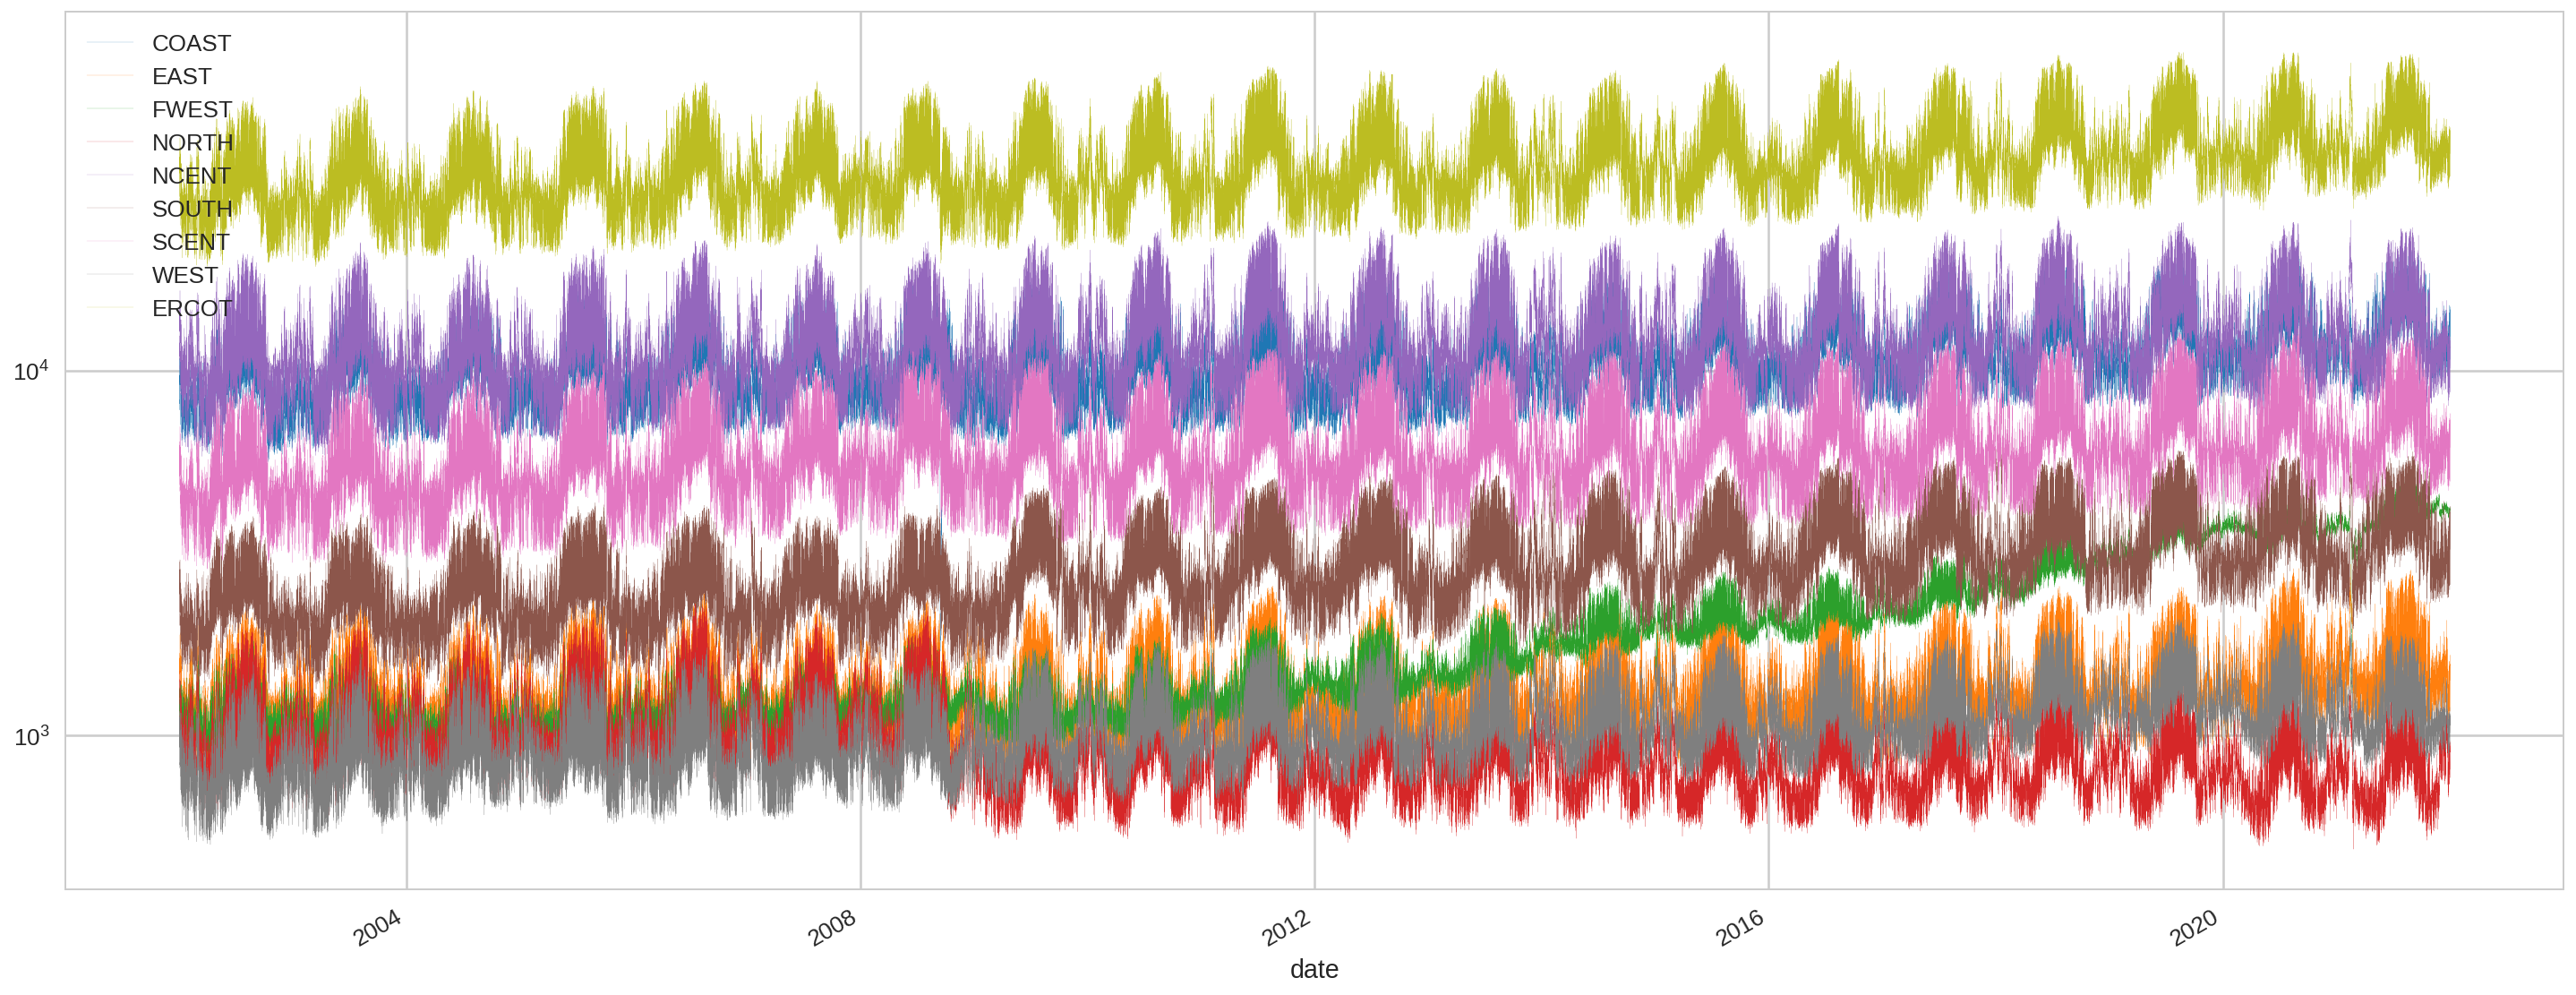

In [298]:
df.plot(figsize=(25,10), linewidth=0.1, logy=True)

In [299]:
len(df)

175320

In [300]:
df [ np.delete(df.columns.values.copy(), -1) ].sum().sum()

6620751083.90497

In [301]:
df.sum().ERCOT

6620812714.870719

In [302]:
df.reset_index().rename({"date": "DATE_TIME"}, axis=1)

,DATE_TIME,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT
0,2002-01-01 01:00:00.003,8331.469266,1111.096549,1094.045496,995.298392,10336.304899,2165.007571,4793.193560,843.747177,29670.162911
1,2002-01-01 01:59:59.997,8107.805431,1091.481584,1083.517981,981.195477,10178.052738,2092.374118,4766.918187,835.488188,29136.833703
2,2002-01-01 03:00:00.000,7890.721717,1080.257616,1085.038740,971.305257,10100.887710,2042.080714,4702.918892,830.694878,28703.905525
3,2002-01-01 04:00:00.003,7799.817527,1079.726403,1093.381853,971.262963,10081.565109,2011.935791,4669.064391,835.068413,28541.822450
4,2002-01-01 04:59:59.997,7815.968171,1087.934961,1106.651296,982.535591,10192.218670,2002.487678,4695.011904,848.598209,28731.406478
...,...,...,...,...,...,...,...,...,...,...
175315,2021-12-31 20:00:00.000,13926.775034,1566.583851,4192.977787,916.124441,11942.416165,3910.031058,7401.098687,1133.093917,44989.100940
175316,2021-12-31 21:00:00.000,13498.908542,1549.687559,4149.062209,886.943872,11406.911057,3681.222926,7088.478765,1102.727285,43363.942215
175317,2021-12-31 22:00:00.000,13116.012129,1515.852644,4148.330779,859.408149,10978.547227,3515.077507,6800.707246,1071.686005,42005.621687
175318,2021-12-31 23:00:00.000,12754.392799,1457.080439,4161.355505,831.148872,10578.729201,3368.125857,6497.990404,1049.414195,40698.237272


# mySQL

In [303]:
import os
from sqlalchemy import create_engine

conn_string = 'mysql+pymysql://{user}:{password}@{host}/?charset=utf8mb4'.format(
    host = 'db.ipeirotis.org', 
    user = 'root',
    password = 'ae6jQniBS5muV27', #os.environ['MYSQL_PASSWORD'],
    encoding = 'utf8mb4')

engine = create_engine(conn_string)
con = engine.connect()

In [304]:
# Query to create a database
db_name = 'ercot'

sql = f"DROP DATABASE IF EXISTS {db_name}"
engine.execute(sql)

# Create a database
sql = f"CREATE DATABASE IF NOT EXISTS {db_name} DEFAULT CHARACTER SET 'utf8mb4'"
engine.execute(sql)

# And lets switch to the database
sql = f"USE {db_name}"
engine.execute(sql)

In [305]:
create_table_sql = '''
CREATE TABLE electricity (
  DATE_TIME datetime,
  COAST    float,
  EAST     float,
  FWEST    float,
  NORTH    float,
  NCENT    float,
  SOUTH    float,
  SCENT    float,
  WEST     float,
  ERCOT    float,
  PRIMARY KEY(DATE_TIME)   
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
engine.execute(create_table_sql)

In [306]:
df.reset_index().rename({"date": "DATE_TIME"}, axis=1).to_sql(
        name = 'electricity', 
        schema = db_name, 
        con = engine,
        if_exists = 'replace',
        index = False, 
        chunksize = 1000)

In [307]:
sql = f'''
GRANT SELECT ON {db_name}.* TO 'student'@'%%'
'''
engine.execute(sql)